In [ ]:
!pip install qiskit==0.37.2

In [2]:
p1 = 0.01
p3 = 3 * p1**2 * (1-p1) + p1**3 # probability of 2 or 3 errors
print('Probability of a single reply being garbled: {}'.format(p1))
print('Probability of a the majority of three replies being garbled: {:.4f}'.format(p3))

Probability of a single reply being garbled: 0.01
Probability of a the majority of three replies being garbled: 0.0003


In [3]:
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import pauli_error, depolarizing_error

def get_noise(p_meas,p_gate):

    error_meas = pauli_error([('X',p_meas), ('I', 1 - p_meas)])
    error_gate1 = depolarizing_error(p_gate, 1)
    error_gate2 = error_gate1.tensor(error_gate1)

    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(error_meas, "measure") # measurement error is applied to measurements
    noise_model.add_all_qubit_quantum_error(error_gate1, ["x"]) # single qubit gate error is applied to x gates
    noise_model.add_all_qubit_quantum_error(error_gate2, ["cx"]) # two qubit gate error is applied to cx gates

    return noise_model

In [4]:
noise_model = get_noise(0.01,0.01)

In [5]:
from qiskit import QuantumCircuit, execute, Aer

qc0 = QuantumCircuit(3,3,name='0') # initialize circuit with three qubits in the 0 state

qc0.measure(qc0.qregs[0],qc0.cregs[0]) # measure the qubits

# run the circuit with th noise model and extract the counts
counts = execute( qc0, Aer.get_backend('qasm_simulator'),noise_model=noise_model).result().get_counts()

print(counts)

{'100': 8, '001': 11, '010': 10, '000': 995}


In [6]:
# ...almost all results still come out '000',...
assert counts['000'] > sum(counts.values())*0.95

In [7]:
qc1 = QuantumCircuit(3, 3, name='0') # initialize circuit with three qubits in the 0 state
qc1.x(qc1.qregs[0]) # flip each 0 to 1

qc1.measure(qc1.qregs[0],qc1.cregs[0]) # measure the qubits

# run the circuit with th noise model and extract the counts
counts = execute(qc1, Aer.get_backend('qasm_simulator'),noise_model=noise_model).result().get_counts()

print(counts)

{'110': 19, '101': 12, '011': 14, '111': 979}


In [8]:
# ...number of samples that come out with a majority in the wrong state
# (0 in this case) is again much less than 10,...
assert counts.get('000', 0) < 10

In [9]:
noise_model = get_noise(0.5,0.0)
counts = execute(qc1, Aer.get_backend('qasm_simulator'),noise_model=noise_model).result().get_counts()
print(counts)

{'001': 128, '100': 125, '110': 133, '011': 119, '111': 119, '101': 123, '010': 148, '000': 129}


In [10]:
# ...all outcomes occur with equal probability, with
# differences in results being due only to statistical noise.
assert max(counts.values()) < 200

In [11]:
from qiskit import QuantumRegister, ClassicalRegister

cq = QuantumRegister(2, 'code_qubit')
lq = QuantumRegister(1, 'ancilla_qubit')
sb = ClassicalRegister(1, 'syndrome_bit')
qc = QuantumCircuit(cq, lq, sb)
qc.cx(cq[0], lq[0])
qc.cx(cq[1], lq[0])
qc.measure(lq, sb)
qc.draw()

code_qubit_0: ──■──────────
                  │          
  code_qubit_1: ──┼────■─────
                ┌─┴─┐┌─┴─┐┌─┐
 ancilla_qubit: ┤ X ├┤ X ├┤M├
                └───┘└───┘└╥┘
syndrome_bit: 1/═══════════╩═
                           0

In [12]:
qc_init = QuantumCircuit(cq, lq, sb)

qc_init.compose(qc).draw()

code_qubit_0: ──■──────────
                  │          
  code_qubit_1: ──┼────■─────
                ┌─┴─┐┌─┴─┐┌─┐
 ancilla_qubit: ┤ X ├┤ X ├┤M├
                └───┘└───┘└╥┘
syndrome_bit: 1/═══════════╩═
                           0

In [13]:
counts = execute(qc_init.compose(qc), Aer.get_backend('qasm_simulator')).result().get_counts()
print('Results:', counts)

Results: {'0': 1024}


In [14]:
# The outcome, in all cases, is 0.
assert list(counts.keys()) == ['0']

The outcome, in all cases, is `0`.

Now let's try an initial state of $\left|11\right\rangle$.

In [15]:
qc_init = QuantumCircuit(cq, lq, sb)
qc_init.x(cq)

qc_init.compose(qc).draw()

┌───┐             
  code_qubit_0: ┤ X ├──■──────────
                ├───┤  │          
  code_qubit_1: ┤ X ├──┼────■─────
                └───┘┌─┴─┐┌─┴─┐┌─┐
 ancilla_qubit: ─────┤ X ├┤ X ├┤M├
                     └───┘└───┘└╥┘
syndrome_bit: 1/════════════════╩═
                                0

In [16]:
counts = execute(qc_init.compose(qc), Aer.get_backend('qasm_simulator')).result().get_counts()
print('Results:', counts)

Results: {'0': 1024}


In [17]:
# The outcome in this case is also always 0.
assert list(counts.keys()) == ['0']

In [18]:
qc_init = QuantumCircuit(cq, lq, sb)
qc_init.h(cq[0])
qc_init.cx(cq[0], cq[1])

qc_init.compose(qc).draw()

┌───┐                  
  code_qubit_0: ┤ H ├──■────■──────────
                └───┘┌─┴─┐  │          
  code_qubit_1: ─────┤ X ├──┼────■─────
                     └───┘┌─┴─┐┌─┴─┐┌─┐
 ancilla_qubit: ──────────┤ X ├┤ X ├┤M├
                          └───┘└───┘└╥┘
syndrome_bit: 1/═════════════════════╩═
                                     0

In [19]:
counts = execute(qc_init.compose(qc), Aer.get_backend('qasm_simulator')).result().get_counts()
print('Results:', counts)

Results: {'0': 1024}


In [20]:
# ...we can expect the same to be true also for
# any superposition of |00⟩ and |11⟩...
assert list(counts.keys()) == ['0']

The opposite outcome will be found for an initial state of $\left|01\right\rangle$, $\left|10\right\rangle$ or any superposition thereof.

In [21]:
qc_init = QuantumCircuit(cq, lq, sb)
qc_init.h(cq[0])
qc_init.cx(cq[0],cq[1])
qc_init.x(cq[0])

qc_init.compose(qc).draw()

┌───┐     ┌───┐             
  code_qubit_0: ┤ H ├──■──┤ X ├──■──────────
                └───┘┌─┴─┐└───┘  │          
  code_qubit_1: ─────┤ X ├───────┼────■─────
                     └───┘     ┌─┴─┐┌─┴─┐┌─┐
 ancilla_qubit: ───────────────┤ X ├┤ X ├┤M├
                               └───┘└───┘└╥┘
syndrome_bit: 1/══════════════════════════╩═
                                          0

In [22]:
counts = execute(qc_init.compose(qc), Aer.get_backend('qasm_simulator')).result().get_counts()
print('Results:',counts)

Results: {'1': 1024}


In [23]:
# In such cases the output is always '1'.
assert list(counts.keys()) == ['1']

In [ ]:
!pip install git+https://github.com/NCCR-SPIN/topological_codes.git

In [26]:
from topological_codes import RepetitionCode
from topological_codes import lookuptable_decoding
from topological_codes import GraphDecoder

In [27]:
n = 3
T = 1

code = RepetitionCode(n, T)

In [28]:
code.circuit['0'].draw()

┌───┐     ┌───┐        ┌─┐         
      link_qubit_0_0: ┤ X ├─────┤ X ├────────┤M├─────────
                      └─┬─┘┌───┐└─┬─┘┌───┐   └╥┘┌─┐      
      link_qubit_0_1: ──┼──┤ X ├──┼──┤ X ├────╫─┤M├──────
                        │  └─┬─┘  │  └─┬─┘┌─┐ ║ └╥┘      
      code_qubit_0_0: ──■────┼────┼────┼──┤M├─╫──╫───────
                             │    │    │  └╥┘ ║  ║ ┌─┐   
      code_qubit_0_1: ───────■────■────┼───╫──╫──╫─┤M├───
                                       │   ║  ║  ║ └╥┘┌─┐
      code_qubit_0_2: ─────────────────■───╫──╫──╫──╫─┤M├
                                           ║  ║  ║  ║ └╥┘
round_0_link_bit_0: 2/═════════════════════╬══╩══╩══╬══╬═
                                           ║  0  1  ║  ║ 
                                           ║        ║  ║ 
        code_bit_0: 3/═════════════════════╩════════╩══╩═
                                           0        1  2

In [29]:
code.circuit['1'].draw()

┌───┐     ┌───┐        ┌─┐         
      link_qubit_0_0: ─────┤ X ├─────┤ X ├────────┤M├─────────
                           └─┬─┘┌───┐└─┬─┘┌───┐   └╥┘┌─┐      
      link_qubit_0_1: ───────┼──┤ X ├──┼──┤ X ├────╫─┤M├──────
                      ┌───┐  │  └─┬─┘  │  └─┬─┘┌─┐ ║ └╥┘      
      code_qubit_0_0: ┤ X ├──■────┼────┼────┼──┤M├─╫──╫───────
                      ├───┤       │    │    │  └╥┘ ║  ║ ┌─┐   
      code_qubit_0_1: ┤ X ├───────■────■────┼───╫──╫──╫─┤M├───
                      ├───┤                 │   ║  ║  ║ └╥┘┌─┐
      code_qubit_0_2: ┤ X ├─────────────────■───╫──╫──╫──╫─┤M├
                      └───┘                     ║  ║  ║  ║ └╥┘
round_0_link_bit_0: 2/══════════════════════════╬══╩══╩══╬══╬═
                                                ║  0  1  ║  ║ 
                                                ║        ║  ║ 
        code_bit_0: 3/══════════════════════════╩════════╩══╩═
                                                0        1  2

In [30]:
def get_raw_results(code,noise_model=None):
    circuits = code.get_circuit_list()
    raw_results = {}
    for log in range(2):
        job = execute( circuits[log], Aer.get_backend('qasm_simulator'), noise_model=noise_model)
        raw_results[str(log)] = job.result().get_counts(str(log))
    return raw_results

raw_results = get_raw_results(code)
for log in raw_results:
    print(f'Logical {log}: {raw_results[log]}')

Logical 0: {'000 00': 1024}
Logical 1: {'111 00': 1024}


In [31]:
code = RepetitionCode(n, 4)

raw_results = get_raw_results(code)
for log in raw_results:
    print(f'Logical {log}: {raw_results[log]}')

Logical 0: {'000 00 00 00 00': 1024}
Logical 1: {'111 00 00 00 00': 1024}


In [32]:
code = RepetitionCode(5, 4)

raw_results = get_raw_results(code)
for log in raw_results:
    print(f'Logical {log}: {raw_results[log]}')

Logical 0: {'00000 0000 0000 0000 0000': 1024}
Logical 1: {'11111 0000 0000 0000 0000': 1024}


In [33]:
code = RepetitionCode(3, 1)

noise_model = get_noise(0.05, 0.05)

raw_results = get_raw_results(code,noise_model)
for log in raw_results:
    print(f'Logical {log}: {raw_results[log]}\n')

Logical 0: {'111 01': 1, '011 10': 1, '011 11': 1, '010 10': 8, '011 01': 2, '110 00': 3, '110 01': 2, '011 00': 3, '010 11': 8, '000 00': 651, '000 10': 56, '100 00': 54, '001 00': 44, '001 10': 9, '010 00': 51, '100 10': 6, '000 01': 71, '101 01': 1, '000 11': 13, '101 00': 7, '010 01': 22, '001 01': 6, '100 01': 3, '110 10': 1}

Logical 1: {'100 11': 2, '011 01': 2, '110 10': 2, '100 01': 1, '010 01': 1, '001 01': 4, '010 10': 3, '011 11': 4, '110 11': 4, '100 00': 5, '001 00': 3, '101 10': 11, '101 00': 45, '001 11': 2, '111 01': 56, '011 00': 50, '001 10': 2, '010 00': 6, '111 10': 65, '011 10': 31, '111 11': 8, '110 00': 44, '110 01': 16, '000 01': 1, '101 11': 10, '111 00': 619, '101 01': 26, '100 10': 1}



In [34]:
circuits = code.get_circuit_list()
table_results = {}
for log in range(2):
    job = execute( circuits[log], Aer.get_backend('qasm_simulator'), noise_model=noise_model, shots=10000 )
    table_results[str(log)] = job.result().get_counts(str(log))

In [35]:
P = lookuptable_decoding(raw_results, table_results)
print('P =', P)

P = {'0': 0.0162, '1': 0.0266}


In [36]:
code = RepetitionCode(3, 2)

raw_results = get_raw_results(code, noise_model)

results = code.process_results(raw_results)

for log in ['0', '1']:
    print(f'\nLogical {log}:')
    print('raw results       ', {string:raw_results[log][string] for string in raw_results[log] if raw_results[log][string]>=50 })
    print('processed results ', {string:results[log][string] for string in results[log] if results[log][string]>=50 })


Logical 0:
raw results        {'000 10 00': 56, '000 10 10': 63, '000 00 00': 494}
processed results  {'0 0  00 10 10': 56, '0 0  10 10 00': 63, '0 0  00 00 00': 494}

Logical 1:
raw results        {'111 01 00': 53, '111 00 00': 443, '111 01 01': 55}
processed results  {'1 1  00 01 01': 53, '1 1  00 00 00': 443, '1 1  01 01 00': 55}


In [37]:
step_2 = False
step_3 = False

In [38]:
from qiskit import IBMQ
from qiskit.compiler import transpile
from qiskit.transpiler import PassManager

In [39]:
device_name = 'ibmq_16_melbourne'

if step_2:

    IBMQ.load_account()

    for provider in IBMQ.providers():
        for potential_backend in provider.backends():
            if potential_backend.name()==device_name:
                backend = potential_backend

    coupling_map = backend.configuration().coupling_map

In [40]:
if device_name=='ibmq_16_melbourne':
    line = [13,14,0,1,2,12,11,3,4,10,9,5,6,8,7]
elif device_name=='ibmq_rochester':
    line = [10,11,17,23,22,21,20,19,16,7,8,9,5]#,0,1,2,3,4,6,13,14,15,18,27,26,25,29,36,37,38,41,50,49,48,47,46,45,44,43,42,39,30,31]

In [41]:
n_min = 3
n_max = int((len(line)+1)/2)

code = {}

for n in range(n_min,n_max+1):
    code[n] = RepetitionCode(n,1)

In [42]:
def get_initial_layout(code,line):
    initial_layout = {}
    for j in range(n):
        initial_layout[code.code_qubit[j]] = line[2*j]
    for j in range(n-1):
        initial_layout[code.link_qubit[j]] = line[2*j+1]
    return initial_layout

In [43]:
if step_2:

    circuits = []
    for n in range(n_min,n_max+1):
        initial_layout = get_initial_layout(code[n],line)
        for log in ['0','1']:
            circuits.append( transpile(code[n].circuit[log], backend=backend, initial_layout=initial_layout) )
            num_cx = dict(circuits[-1].count_ops())['cx']
            assert num_cx==2*(n-1), str(num_cx) + ' instead of ' + str(2*(n-1)) + ' cx gates for n = ' + str(n)

In [44]:
if step_2:

    job = execute(circuits,backend,shots=8192)

    raw_results = {}
    j = 0
    for d in range(n_min,n_max+1):
        raw_results[d] = {}
        for log in ['0','1']:
            raw_results[d][log] = job.result().get_counts(j)
            j += 1

In [45]:
if step_2: # save results
    with open('results/raw_results_'+device_name+'.txt', 'w') as file:
        file.write(str(raw_results))
elif step_3: # read results
    with open('results/raw_results_'+device_name+'.txt', 'r') as file:
        raw_results = eval(file.read())

In [46]:
if step_3:
    results = {}
    for n in range(n_min,n_max+1):
        results[n] = code[n].process_results( raw_results[n] )

In [47]:
if step_3:
    dec = {}
    for n in range(n_min,n_max+1):
        dec[n] = GraphDecoder(code[n])

In [49]:
if step_3:

    logical_prob_match = {}
    for n in range(n_min,n_max+1):
        logical_prob_match[n] = dec[n].get_logical_prob(results[n])

    with open('./logical_prob_match_'+device_name+'.txt', 'w') as file:
        file.write(str(logical_prob_match))

else:
    with open('./logical_prob_match_'+device_name+'.txt', 'r') as file:
        logical_prob_match = eval(file.read())

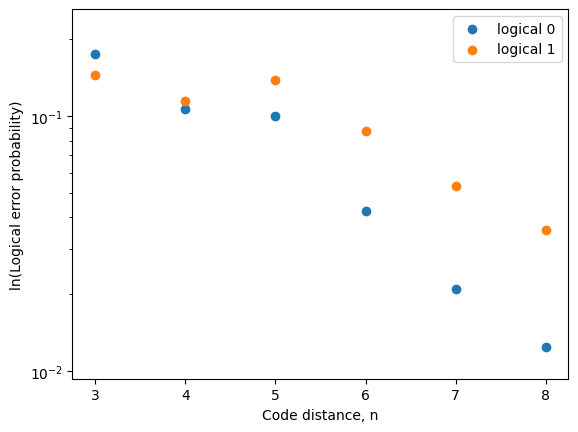

In [50]:
import matplotlib.pyplot as plt
import numpy as np

x_axis = range(n_min,n_max+1)
P = { log: [logical_prob_match[n][log] for n in x_axis] for log in ['0', '1'] }

ax = plt.gca()
plt.xlabel('Code distance, n')
plt.ylabel('ln(Logical error probability)')
ax.scatter( x_axis, P['0'], label="logical 0")
ax.scatter( x_axis, P['1'], label="logical 1")
ax.set_yscale('log')
ax.set_ylim(ymax=1.5*max(P['0']+P['1']),ymin=0.75*min(P['0']+P['1']))
plt.legend()

plt.show()

In [51]:
if step_3:

    dec[n_max].weight_syndrome_graph(results=results[n_max])

    probs = []
    for edge in dec[n_max].S.edges:
        ratio = np.exp(-dec[n_max].S.get_edge_data(edge[0],edge[1])['distance'])
        probs.append( ratio/(1+ratio) )

    with open('./probs_'+device_name+'.txt', 'w') as file:
        file.write(str(probs))

else:

    with open('./probs_'+device_name+'.txt', 'r') as file:
        probs = eval(file.read())

In [52]:
import pandas as pd

pd.Series(probs).describe().to_dict()

{'count': 29.0,
 'mean': 0.1839624024105741,
 'std': 0.08969281029182916,
 'min': 0.032099523882660116,
 '25%': 0.1202076677316294,
 '50%': 0.15479808944854537,
 '75%': 0.2585266030013643,
 'max': 0.3820573455512858}

In [53]:
if step_3:

    gate_probs = []
    for j,qubit in enumerate(line):

        gate_probs.append( backend.properties().readout_error(qubit) )

        cx1,cx2 = 0,0
        if j>0:
            gate_probs( backend.properties().gate_error('cx',[qubit,line[j-1]]) )
        if j<len(line)-1:
            gate_probs( backend.properties().gate_error('cx',[qubit,line[j+1]]) )

    with open('./gate_probs_'+device_name+'.txt', 'w') as file:
        file.write(str(gate_probs))

else:

    with open('./gate_probs_'+device_name+'.txt', 'r') as file:
        gate_probs = eval(file.read())

pd.Series(gate_probs).describe().to_dict()

{'count': 43.0,
 'mean': 0.03964249408264689,
 'std': 0.022274869416574618,
 'min': 0.01279016878072245,
 '25%': 0.025389504940856747,
 '50%': 0.03296455263355727,
 '75%': 0.046331516695269206,
 'max': 0.11660000000000004}

In [54]:
import qiskit
qiskit.__qiskit_version__

{'qiskit-terra': '0.21.2', 'qiskit-aer': '0.10.4', 'qiskit-ignis': None, 'qiskit-ibmq-provider': '0.19.2', 'qiskit': '0.37.2', 'qiskit-nature': None, 'qiskit-finance': None, 'qiskit-optimization': None, 'qiskit-machine-learning': None}


Simulating Code Distance 3...
Code Distance 3: Logical 0 -> 0.0009, Logical 1 -> 0.0010

Simulating Code Distance 5...
Code Distance 5: Logical 0 -> 0.0000, Logical 1 -> 0.0000

Simulating Code Distance 7...
Code Distance 7: Logical 0 -> 0.0000, Logical 1 -> 0.0000


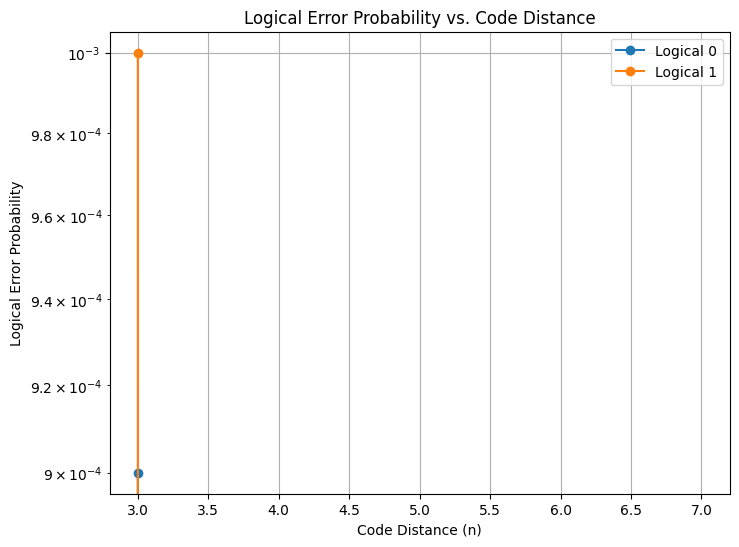

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, Aer, execute
from qiskit.providers.aer.noise import NoiseModel, pauli_error, depolarizing_error
from qiskit.exceptions import QiskitError as NoiseError
from qiskit.circuit.library import XGate, CXGate
from topological_codes import RepetitionCode, lookuptable_decoding

# Define the noise model
def get_noise(p_meas, p_gate):
    """
    Create a noise model for simulation.

    Parameters:
        p_meas: Probability of measurement error.
        p_gate: Probability of gate error.

    Returns:
        NoiseModel: The noise model for the simulator.
    """
    # Define measurement error
    error_meas = pauli_error([("X", p_meas), ("I", 1 - p_meas)])

    # Define single-qubit gate depolarizing error
    error_gate1 = depolarizing_error(p_gate, 1)

    # Define two-qubit gate depolarizing error
    error_gate2 = depolarizing_error(p_gate, 2)

    # Create the noise model
    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(error_meas, "measure")  # Measurement error
    noise_model.add_all_qubit_quantum_error(error_gate1, ["x", "h"])  # Single-qubit gate errors
    noise_model.add_all_qubit_quantum_error(error_gate2, ["cx"])  # Two-qubit gate errors

    return noise_model

# Function to run the simulation and compute results
def simulate_repetition_code(n_values, p_meas, p_gate, shots=10000):
    """
    Simulate the repetition code with noise.

    Parameters:
        n_values: List of code distances (e.g., [3, 5, 7]).
        p_meas: Probability of measurement error.
        p_gate: Probability of gate error.
        shots: Number of shots for the simulation.

    Returns:
        results: Dictionary of logical error probabilities for each code distance.
    """
    noise_model = get_noise(p_meas, p_gate)
    results = {}

    for n in n_values:
        print(f"\nSimulating Code Distance {n}...")
        code = RepetitionCode(n, 1)  # Single round of error correction
        raw_results = {}

        # Simulate logical 0 and logical 1
        for log in ['0', '1']:
            circuit = code.circuit[log]
            job = execute(circuit, Aer.get_backend('qasm_simulator'), noise_model=noise_model, shots=shots)
            raw_results[log] = job.result().get_counts()

        # Decode and compute logical error probabilities
        table_results = {}
        for log in ['0', '1']:
            table_results[log] = raw_results[log]
        logical_probs = lookuptable_decoding(raw_results, table_results)
        results[n] = logical_probs

        print(f"Code Distance {n}: Logical 0 -> {logical_probs['0']:.4f}, Logical 1 -> {logical_probs['1']:.4f}")

    return results

# Plot results
def plot_results(results):
    """
    Plot the logical error probabilities.

    Parameters:
        results: Dictionary of logical error probabilities for each code distance.
    """
    code_distances = list(results.keys())
    logical_0_probs = [results[n]['0'] for n in code_distances]
    logical_1_probs = [results[n]['1'] for n in code_distances]

    plt.figure(figsize=(8, 6))
    plt.plot(code_distances, logical_0_probs, label="Logical 0", marker='o')
    plt.plot(code_distances, logical_1_probs, label="Logical 1", marker='o')
    plt.yscale('log')
    plt.xlabel("Code Distance (n)")
    plt.ylabel("Logical Error Probability")
    plt.title("Logical Error Probability vs. Code Distance")
    plt.legend()
    plt.grid()
    plt.show()

# Main Execution
if __name__ == "__main__":
    # Simulation parameters
    n_values = range(3, 9, 2)  # Code distances
    p_meas, p_gate = 0.01, 0.01  # Measurement and gate error probabilities
    shots = 10000  # Number of shots

    # Simulate and plot results
    results = simulate_repetition_code(n_values, p_meas, p_gate, shots=shots)
    plot_results(results)


In [ ]:
!pip install qiskit[visualization]

In [2]:
import random

# Custom encoding function using Repetition Code
def encode_message(message, d):
    """
    Encodes the message using a repetition code.

    Args:
        message (list): A list of logical bits (0 or 1).
        d (int): The repetition factor (number of times each bit is repeated).

    Returns:
        list: A list of encoded messages where each bit is repeated d times.
    """
    encoded_message = []
    for bit in message:
        encoded_bit = [bit] * d  # Repeat the bit d times
        encoded_message.append(encoded_bit)
    return encoded_message


# Custom decoding function using Majority Voting
def decode_message(encoded_message):
    """
    Decodes the message using majority voting.

    Args:
        encoded_message (list): The encoded message with repeated bits.

    Returns:
        list: The decoded message as a list of logical bits (0 or 1).
    """
    decoded_message = []
    for encoded_bit in encoded_message:
        majority_bit = max(set(encoded_bit), key=encoded_bit.count)  # Majority voting
        decoded_message.append(majority_bit)
    return decoded_message


# Apply noise to the encoded message by flipping bits with some probability
def apply_noise(encoded_message, p_noise):
    """
    Simulates noise by flipping a random bit with probability p_noise.

    Args:
        encoded_message (list): The encoded message.
        p_noise (float): The probability of flipping a bit.

    Returns:
        list: The noisy encoded message.
    """
    noisy_message = encoded_message.copy()
    for i in range(len(noisy_message)):
        for j in range(len(noisy_message[i])):
            if random.random() < p_noise:  # Flip the bit
                noisy_message[i][j] = 1 - noisy_message[i][j]
    return noisy_message


# Implementing a simple lookup table decoding function (majority voting in this case)
def lookuptable_decoding(training_results, real_results):
    """
    Decodes the message using lookup table decoding based on the training results.

    Args:
        training_results (dict): A dictionary of training results with logical state as key.
        real_results (dict): A dictionary of real noisy results with logical state as key.

    Returns:
        dict: The decoded logical state probabilities.
    """
    logical_prob = {}

    for log in real_results:
        shots = 0
        incorrect_shots = 0
        for string in real_results[log]:
            p = {"0": 0, "1": 0}

            # Calculate the probability of this string being a logical '0' or '1'
            for testlog in ["0", "1"]:
                if string in training_results[testlog]:
                    p[testlog] = training_results[testlog][string]

            shots += real_results[log][string]
            # If the incorrect logical state (e.g., '1' for logical '0') has a higher probability, it's an error
            if p["1" * (log == "0") + "0" * (log == "1")] > p[log]:
                incorrect_shots += real_results[log][string]

        logical_prob[log] = incorrect_shots / shots if shots > 0 else 0

    return logical_prob


# Custom function to compare the original key with the decoded key
def compare_keys(original_key, decoded_key):
    """
    Compares the original key with the decoded key and prints if the error correction was successful.

    Args:
        original_key (list): The original message.
        decoded_key (list): The decoded message.
    """
    if original_key == decoded_key:
        print("Error correction successful!")
    else:
        print("Error correction failed!")
    print("Original Key:", original_key)
    print("Decoded Key:", decoded_key)


# Main function to run the example
def main():
    # Define the original key (message)
    original_key = [1, 0, 1, 1, 0]  # Example binary message

    # Set the repetition factor (d)
    d = 3  # Repetition factor for encoding

    # Encode the message using repetition code
    encoded_message = encode_message(original_key, d)
    print("Encoded Message:", encoded_message)

    # Simulate noise on the encoded message (10% noise)
    p_noise = 0.1  # Noise probability
    noisy_message = apply_noise(encoded_message, p_noise)
    print("Noisy Encoded Message:", noisy_message)

    # Decode without error correction (simply taking the first bit of each repeated group)
    no_error_correction_decoded = [bits[0] for bits in noisy_message]
    print("Decoded Message (No Error Correction):", no_error_correction_decoded)

    # Decode with error correction using majority voting
    decoded_message = decode_message(noisy_message)
    print("Decoded Message (With Error Correction):", decoded_message)

    # Compare the original and decoded keys (No Error Correction)
    print("\nComparison without Error Correction:")
    compare_keys(original_key, no_error_correction_decoded)

    # Compare the original and decoded keys (With Error Correction)
    print("\nComparison with Error Correction:")
    compare_keys(original_key, decoded_message)

# Run the main function
if __name__ == "__main__":
    main()



# Run the main function
if __name__ == "__main__":
    main()


Encoded Message: [[1, 1, 1], [0, 0, 0], [1, 1, 1], [1, 1, 1], [0, 0, 0]]
Noisy Encoded Message: [[1, 1, 1], [0, 0, 0], [1, 1, 1], [1, 1, 1], [0, 0, 0]]
Decoded Message (No Error Correction): [1, 0, 1, 1, 0]
Decoded Message (With Error Correction): [1, 0, 1, 1, 0]

Comparison without Error Correction:
Error correction successful!
Original Key: [1, 0, 1, 1, 0]
Decoded Key: [1, 0, 1, 1, 0]

Comparison with Error Correction:
Error correction successful!
Original Key: [1, 0, 1, 1, 0]
Decoded Key: [1, 0, 1, 1, 0]
Encoded Message: [[1, 1, 1], [0, 0, 0], [1, 1, 1], [1, 1, 1], [0, 0, 0]]
Noisy Encoded Message: [[1, 1, 1], [0, 0, 0], [1, 1, 1], [1, 1, 1], [1, 0, 1]]
Decoded Message (No Error Correction): [1, 0, 1, 1, 1]
Decoded Message (With Error Correction): [1, 0, 1, 1, 1]

Comparison without Error Correction:
Error correction failed!
Original Key: [1, 0, 1, 1, 0]
Decoded Key: [1, 0, 1, 1, 1]

Comparison with Error Correction:
Error correction failed!
Original Key: [1, 0, 1, 1, 0]
Decoded Key